# Un-coupled phase separation

- Code for Cahn-Hilliard phase separation without mechanical coupling

- This is a two-dimensional simulation

# Degrees of freedom
- chemical potential: mu
- concentration: c

# Units
- Length: um
- Mass: kg
- Time: s
- Amount of substance: pmol
- Temperature: K

- Mass density: kg/um^3
- Force: uN
- Stress: MPa 
- Energy: pJ
- Species concentration: pmol/um^3
- Chemical potential: pJ/pmol
- Molar volume: um^3/pmol
- Species diffusivity: um^2/s
- Boltzmann Constant: 1.38E-11 pJ/K
- Gas constant: 8.3145  pJ/(pmol K)


### Software:
- Dolfinx v0.8.0


In the collection "Example Codes for Coupled Theories in Solid Mechanics,"

By Eric M. Stewart, Shawn A. Chester, and Lallit Anand.

https://solidmechanicscoupledtheories.github.io/

# Import modules

In [1]:
# Import FEniCSx/dolfinx
import dolfinx

# For numerical arrays
import numpy as np

# For MPI-based parallelization
from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()

# PETSc solvers
from petsc4py import PETSc

# specific functions from dolfinx modules
from dolfinx import fem, mesh, io, plot, log
from dolfinx.fem import (Constant, dirichletbc, Function, functionspace, Expression )
from dolfinx.fem.petsc import NonlinearProblem
from dolfinx.nls.petsc import NewtonSolver
from dolfinx.io import VTXWriter, XDMFFile

# specific functions from ufl modules
import ufl
from ufl import (TestFunctions, TrialFunction, Identity, grad, det, div, dev, inv, tr, sqrt, conditional ,\
                 lt, gt, dx, inner, derivative, dot, ln, split, exp, eq, cos, sin, acos, ge, le, outer, tanh,\
                 cosh, atan, atan2)

# basix finite elements (necessary for dolfinx v0.8.0)
import basix
from basix.ufl import element, mixed_element

# Matplotlib for plotting
import matplotlib.pyplot as plt
plt.close('all')

# For timing the code
from datetime import datetime

# Set level of detail for log messages (integer)
# Guide:
# CRITICAL  = 50, // errors that may lead to data corruption
# ERROR     = 40, // things that HAVE gone wrong
# WARNING   = 30, // things that MAY go wrong later
# INFO      = 20, // information of general interest (includes solver info)
# PROGRESS  = 16, // what's happening (broadly)
# TRACE     = 13, // what's happening (in detail)
# DBG       = 10  // sundry
#
log.set_log_level(log.LogLevel.WARNING)

# Define geometry

In [2]:
# Create square mesh 
L0 = 0.8 # 800 nm box. After Di Leo et al. (2014) 

# Number of elements along each side
N = 100

domain = mesh.create_rectangle(MPI.COMM_WORLD, [[0.0,0.0], [L0,L0]],\
                         [N,N], mesh.CellType.quadrilateral)

# domain = mesh.create_rectangle(MPI.COMM_WORLD, [[0.0,0.0], [L0,L0]],\
#                          [N,N], mesh.CellType.triangle, diagonal=mesh.DiagonalType.crossed)
                         
x = ufl.SpatialCoordinate(domain)

**Identify the boundaries of the domain**

In [3]:
# Identify the boundaries of the  rectangle mesh
#
def xBot(x):
    return np.isclose(x[0], 0)
def xTop(x):
    return np.isclose(x[0], L0)
def yBot(x):
    return np.isclose(x[1], 0)
def yTop(x):
    return np.isclose(x[1], L0)
    
# Mark the sub-domains
boundaries = [(1, xBot),(2,xTop),(3,yBot),(4,yTop)]

# Build collections of facets on each subdomain and mark them appropriately.
facet_indices, facet_markers = [], [] # initalize empty collections of indices and markers.
fdim = domain.topology.dim - 1        # geometric dimension of the facet (mesh dimension - 1)
for (marker, locator) in boundaries:
    facets = mesh.locate_entities(domain, fdim, locator) # an array of all the facets in a 
                                                         # given subdomain ("locator")
    facet_indices.append(facets)                         # add these facets to the collection.
    facet_markers.append(np.full_like(facets, marker))   # mark them with the appropriate index.

# Format the facet indices and markers as required for use in dolfinx.
facet_indices = np.hstack(facet_indices).astype(np.int32)
facet_markers = np.hstack(facet_markers).astype(np.int32)
sorted_facets = np.argsort(facet_indices)
# 
# Add these marked facets as "mesh tags" for later use in BCs.
facet_tags = mesh.meshtags(domain, fdim, facet_indices[sorted_facets], facet_markers[sorted_facets])

**Visualize the reference configuration**

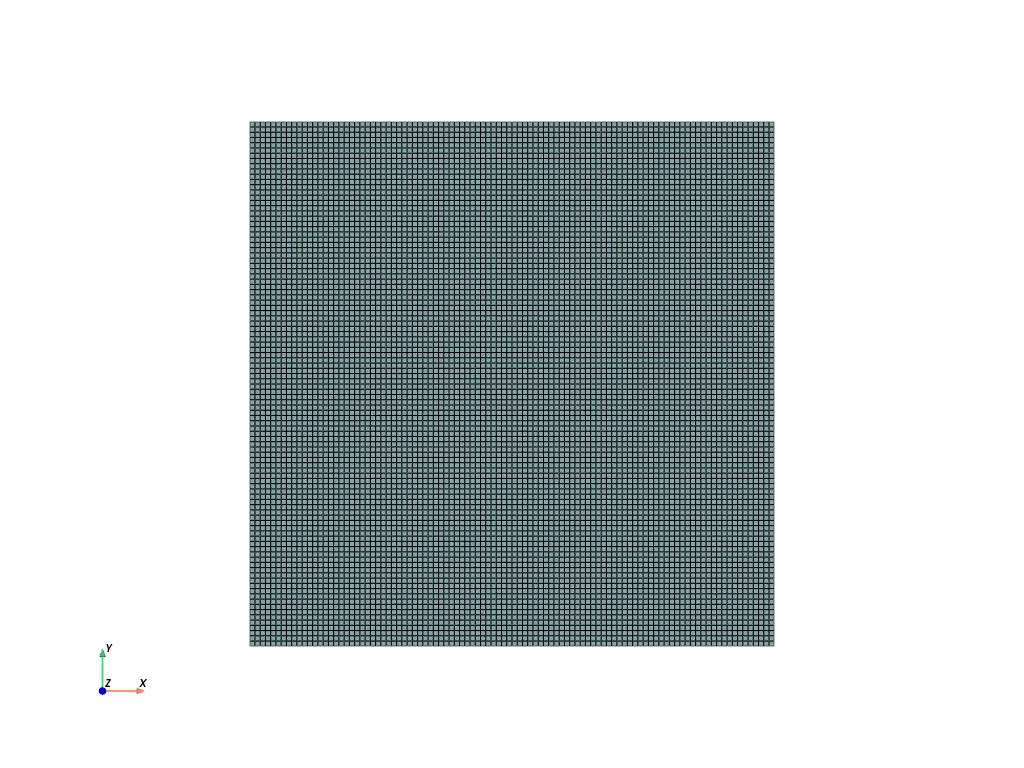

In [4]:
import pyvista
pyvista.set_jupyter_backend('html')
from dolfinx.plot import vtk_mesh
pyvista.start_xvfb()

# initialize a plotter
plotter = pyvista.Plotter()

# Add the mesh.
topology, cell_types, geometry = plot.vtk_mesh(domain, domain.topology.dim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
plotter.add_mesh(grid, show_edges=True) #, opacity=0.25) 

plotter.view_xy()

#labels = dict(xlabel='X', ylabel='Y',zlabel='Z')
labels = dict(xlabel='X', ylabel='Y')
plotter.add_axes(**labels)

plotter.screenshot("results/square_mesh.png")

from IPython.display import Image
Image(filename='results/square_mesh.png') 

# # Use the following  commands for a  zoom-able  view
# if not pyvista.OFF_SCREEN:
#     plotter.show()
# else:
#     plotter.screenshot("square_mesh.png")

## Define boundary and volume integration measure

In [5]:
# Define the boundary integration measure "ds" using the facet tags,
# also specify the number of surface quadrature points.
ds = ufl.Measure('ds', domain=domain, subdomain_data=facet_tags, metadata={'quadrature_degree':4})

# Define the volume integration measure "dx" 
# also specify the number of volume quadrature points.
dx = ufl.Measure('dx', domain=domain, metadata={'quadrature_degree': 4})

# Create facet to cell connectivity required to determine boundary facets.
domain.topology.create_connectivity(domain.topology.dim, domain.topology.dim)
domain.topology.create_connectivity(domain.topology.dim, domain.topology.dim-1)
domain.topology.create_connectivity(domain.topology.dim-1, domain.topology.dim)

# #  Define facet normal
n2D = ufl.FacetNormal(domain)
n = ufl.as_vector([n2D[0], n2D[1], 0.0]) # define n as a 3D vector for later use

# Material parmeters

In [6]:
# Material parameters after Di Leo et al. (2014)
#
Omega    = Constant(domain,PETSc.ScalarType(4.05))      # Molar volume, um^3/pmol 
D        = Constant(domain,PETSc.ScalarType(1e-2))      # Diffusivity, um^2/s 
chi      = Constant(domain,PETSc.ScalarType(3))         # Phase parameter, (-)
cMax     = Constant(domain,PETSc.ScalarType(2.29e-2))   # Saturation concentration, pmol/um^3
lam      = Constant(domain,PETSc.ScalarType(5.5749e-1)) # Interface parameter, (pJ/pmol) um^2
#
theta0   =Constant(domain,PETSc.ScalarType(298))        # Reference temperature, K
R_gas    = Constant(domain,PETSc.ScalarType(8.3145))    # Gas constant, pJ/(pmol K)
RT       = Constant(domain,PETSc.ScalarType(R_gas*theta0))


# Simulation time-control related parameters

In [7]:
t    = 0.0   # Initialization of time
Ttot = 2000  # Total time
dt   = 0.01  # Initial time step size, here we will use adaptive time-stepping

# Time step field, constant within body
dk = Constant(domain, PETSc.ScalarType(dt))

# Function spaces

In [8]:
# Define function space, scalar
# 
P1 = element("Lagrange", domain.basix_cell(), 1) # For chemical potential and species concentration 
#                                      
TH = mixed_element([P1, P1])     # Mixed element
ME = functionspace(domain, TH)   # Total space for all DOFs

# Define actual functions with the required DOFs
w = Function(ME)
mu, c = split(w)  # chemical potential mu and concentration c

# A copy of functions to store values in the previous step for time-stepping
w_old = Function(ME)
mu_old, c_old = split(w_old)   

# Define test functions    
mu_test, c_test  = TestFunctions(ME)  

# Define trial functions needed for automatic differentiation
dw = TrialFunction(ME)                  

# Initial conditions for cBar


In [9]:
# Construct a function for specifying a  random spatially-varying normalized concentration field "cBar"
#
Vmat = functionspace(domain, ("DG", 0)) # Create a DG0 function space on the domain

#  Define a  function for assigning different value  at each coordinate of the domain,
#  including  a randomly-generated variance 
#
def rand_cBar(avg, var):

    # initialize the random number generator
    #
    rng = np.random.default_rng(42)

    # Define an empty "cBar" function,
    # which lives on the target DG0 function space
    #
    cBar = Function(Vmat)
    
    # Now, actualy assign the desired values of the concentration to the new field
    #
    # First identify the coordinates of the domain
    #
    coords = Vmat.tabulate_dof_coordinates()
    #
    # Then loop over the coordinates and assign a randomly-generated value
    #
    for i in range(coords.shape[0]):
        
            cBar_val = avg + var * (0.5 - rng.random())
            cBar.vector.setValueLocal(i, cBar_val)
            
    return cBar

# Specify a random distribution of intial values of  cBar.
# Note that in the example below, the mean value of cBar will be 0.63 and
# the maximum variation will be \pm (var*0.5)=0.05
#
cBar_init = rand_cBar(0.63, 0.1) 

# Initial conditions for degrees of freedom c and mu

In [10]:
# Get a scalar function space for interpolating initial conditions.
V1 = functionspace(domain, P1) 

# write and interpolate the expression for initial normalized concentration c
#
c_init_expr = Expression(Omega*cMax*cBar_init, V1.element.interpolation_points())
#
w.sub(1).interpolate(c_init_expr)
w_old.sub(1).interpolate(c_init_expr)

# Write and inteprolate the expression for initial  normalized chemical potential
#
mu_init_expr = Expression(ln(cBar_init/(1-cBar_init)) + chi*(1-2*cBar_init), V1.element.interpolation_points() )
#
w.sub(0).interpolate(mu_init_expr)
w_old.sub(0).interpolate(mu_init_expr)

# Subroutines for kinematics and constitutive equations

In [11]:
# Special gradient operators for plane strain 
# The plane strain forms are actually not needed for thsi problem,
# but we might need such forms if we were to do am chemo-mechanically coupled simualtion later
#
# Gradient of vector field u   
def pe_grad_vector(u):
    
    grad_u = grad(u)
    
    pe_grad_u = ufl.as_tensor([ [grad_u[0,0], grad_u[0,1], 0.0],
                                [grad_u[1,0], grad_u[1,1], 0.0],
                                [        0.0,         0.0, 0.0] ]) 
    return pe_grad_u

# Gradient of scalar field y
# (just need an extra zero for dimensions to work out)
def pe_grad_scalar(y):
    
    grad_y = grad(y)
    
    pe_grad_y = ufl.as_vector([grad_y[0], grad_y[1], 0.0])
    
    return pe_grad_y


    return Piola

# Species flux
def Flux_calc(mu, c):
    #
    cBar = c/(Omega*cMax) # normalized concentration
    #
    Mob = (D*c)/(Omega*RT)*(1-cBar)
    #
    Jmat = - RT* Mob * pe_grad_scalar(mu)
    return Jmat

# Calculate the f^c term
def fc_calc(c):
    #
    cBar = c/(Omega*cMax) # normalized concentration
    #
    fc   = RT*(ln(cBar/(1-cBar)) + chi*(1-2*cBar) ) 
    #
    return fc

# Evaluate kinematics and constitutive relations

In [12]:
# Calculate the normalized concentration cBar
cBar = c/(Omega*cMax)  

# Calculate the Species flux
Jmat = Flux_calc(mu, c)

# Calculate the f^c term 
fc = fc_calc(c)

# Weak forms

In [13]:
# Residuals:
# Res_0: Balance of mass   (test fxn: mu)
# Res_1: chemical potential (test fxn: c)

# The weak form for the mass balance of mobile species    
Res_0 = dot((c - c_old)/dk, mu_test)*dx \
        -  Omega*dot(Jmat , pe_grad_scalar(mu_test) )*dx      

# The weak form for the concentration
Res_1 = dot(mu - fc/RT, c_test)*dx \
        -  dot( (lam/RT)*pe_grad_scalar(cBar), pe_grad_scalar(c_test))*dx
        
# Total weak form
Res = Res_0 + Res_1

# Automatic differentiation tangent:
a = derivative(Res, w, dw)

# Set-up output files

In [14]:
# Results file name
results_name = "2D_uncoupled_phase_separation"

# Function space for projection of results
P0 = element("DG", domain.basix_cell(), 1) # For  chemical potential, and concentration 
 
V1 = fem.functionspace(domain, P0)         # Scalar function space
 

# Basic fields to write to output file
mu_vis = Function(V1)
mu_vis.name = "mu"

c_vis = Function(V1)
c_vis.name = "c"

# Calculated field to write to output file
cBar_vis = Function(V1)
cBar_vis.name = "cBar"
cBar_expr = Expression(cBar,V1.element.interpolation_points())

# Set up the output VTX files.
file_results = VTXWriter(
    MPI.COMM_WORLD,
    "results/" + results_name + ".bp",
    [  # put the functions here you wish to write to output
        mu_vis, c_vis, cBar_vis,
    ],
    engine="BP4",
)

def writeResults(t):
       # Output field interpolation 
       mu_vis.interpolate(w.sub(0))
       c_vis.interpolate(w.sub(1))
       cBar_vis.interpolate(cBar_expr)
       # Write output fields
       file_results.write(t)        

# Analysis Step 

In [15]:
# Give the step a descriptive name
step = "Phase-separate"

## Boundary conditions

In [16]:
# Nothing! Just let the system evolve on its own.
bcs = []

## Define the nonlinear variational problem

In [17]:
# Set up nonlinear problem
problem = NonlinearProblem(Res, w, bcs, a)

# The global newton solver and params
solver = NewtonSolver(MPI.COMM_WORLD, problem)
solver.convergence_criterion = "incremental"
solver.rtol = 1e-8
solver.atol = 1e-8
solver.max_it = 50
solver.report = True
solver.error_on_nonconvergence = False

#  The Krylov solver parameters.
ksp = solver.krylov_solver
opts = PETSc.Options()
option_prefix = ksp.getOptionsPrefix()
opts[f"{option_prefix}ksp_type"] = "preonly"  
opts[f"{option_prefix}pc_type"] = "lu" # do not use 'gamg' pre-conditioner
opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
opts[f"{option_prefix}ksp_max_it"] = 30
ksp.setFromOptions()

# Initialize arrays for storing output history

In [18]:
# # Arrays for storing output history
# # totSteps = 100000
# # timeHist0 = np.zeros(shape=[totSteps])
# # timeHist1 = np.zeros(shape=[totSteps]) 
# # timeHist2 = np.zeros(shape=[totSteps]) 
# # timeHist3 = np.zeros(shape=[totSteps])
# # #
# # timeHist3[0] = mu0 # Initialize the chemical potential

# Initialize a counter for reporting data
ii = 0

# Write initial state to file
writeResults(t=0.0) 

##  Start calculation loop

In [19]:
print("------------------------------------")
print("Simulation start")
print("------------------------------------")
# Store start time 
startTime = datetime.now()

# Time-stepping solution procedure loop
while (round(t + dt, 9) <= Ttot):
     
    # increment time
    t += dt 
    # increment counter
    ii += 1
       
    # Solve the problem
    (iter, converged) = solver.solve(w)
    
    # Now we start the adaptive time-stepping procedure
    #
    # First, we check if the newton solver actually converged.
    if converged: 

        # Collect results from MPI ghost processes
        w.x.scatter_forward()
        
        # Write output to file
        writeResults(t)

        # If the solver converged, we print the status of the solver, 
        # perform adaptive time-stepping updates, output results, and 
        # update degrees of freedom for the next step, w_old <- w.
        
        # print progress of calculation periodically
        if ii%1 == 0:      
            now = datetime.now()
            current_time = now.strftime("%H:%M:%S")
            print("Step: {} |   Increment: {} | Iterations: {}".format(step, ii, iter))
            print("Simulation Time: {} s | dt: {} s".format(round(t,2), round(dt, 3)))
            print()   
        
        # Iteration-based adaptive time-stepping
        #
        # If the newton solver takes 2 or less iterations, 
        # increase the time step by a factor of 1.5:
        if ((iter<=4) and (dt<25)):
            dt = 1.5*dt
            dk.value = dt
        # If the newton solver takes 8 or more iterations, 
        # decrease the time step by a factor of 2:
        elif iter>=8:
            dt = dt/2
            dk.value = dt
        # otherwise the newton solver took 3-4 iterations,
        # in which case leave the time step alone

        # update the DOFs for the next step.
        w_old.x.array[:] = w.x.array
    
    # If the solver doesn't converge we have to back up in time,
    # cut the size of the time step, and try solving again.
    else: # not(converged)
        
        # first, we back up in time
        # ( to undo the current time step )
        t = t - float(dk)
        
        # Then, we cut back on the time step we're attempting.
        # (by a factor of 2)
        dt = dt/2
        dk.value = dt 

        # Re-set the DOFs to their value before the failed step.
        w.x.array[:] = w_old.x.array

        # Set up nonlinear problem
        problem = NonlinearProblem(Res, w, bcs, a)

        # The global newton solver and params
        solver = NewtonSolver(MPI.COMM_WORLD, problem)
        solver.convergence_criterion = "incremental"
        solver.rtol = 1e-8
        solver.atol = 1e-8
        solver.max_it = 50
        solver.report = True
        solver.error_on_nonconvergence = False
    
# close the output file.
file_results.close()
         
# End analysis
print("-----------------------------------------")
print("End computation")                 
# Report elapsed real time for the analysis
endTime = datetime.now()
elapseTime = endTime - startTime
print("------------------------------------------")
print("Elapsed real time:  {}".format(elapseTime))
print("------------------------------------------")

------------------------------------
Simulation start
------------------------------------
Step: Phase-separate |   Increment: 1 | Iterations: 4
Simulation Time: 0.01 s | dt: 0.01 s

Step: Phase-separate |   Increment: 2 | Iterations: 3
Simulation Time: 0.03 s | dt: 0.015 s

Step: Phase-separate |   Increment: 3 | Iterations: 3
Simulation Time: 0.05 s | dt: 0.022 s

Step: Phase-separate |   Increment: 4 | Iterations: 4
Simulation Time: 0.08 s | dt: 0.034 s

Step: Phase-separate |   Increment: 5 | Iterations: 4
Simulation Time: 0.13 s | dt: 0.051 s

Step: Phase-separate |   Increment: 6 | Iterations: 4
Simulation Time: 0.21 s | dt: 0.076 s



2025-02-14 19:17:26.017 (   5.179s) [main            ]       NewtonSolver.cpp:270   WARN| Newton solver did not converge.


Step: Phase-separate |   Increment: 8 | Iterations: 4
Simulation Time: 0.26 s | dt: 0.057 s

Step: Phase-separate |   Increment: 9 | Iterations: 7
Simulation Time: 0.35 s | dt: 0.085 s



2025-02-14 19:17:26.934 (   6.096s) [main            ]       NewtonSolver.cpp:270   WARN| Newton solver did not converge.


Step: Phase-separate |   Increment: 11 | Iterations: 5
Simulation Time: 0.39 s | dt: 0.043 s

Step: Phase-separate |   Increment: 12 | Iterations: 5
Simulation Time: 0.44 s | dt: 0.043 s

Step: Phase-separate |   Increment: 13 | Iterations: 5
Simulation Time: 0.48 s | dt: 0.043 s

Step: Phase-separate |   Increment: 14 | Iterations: 5
Simulation Time: 0.52 s | dt: 0.043 s

Step: Phase-separate |   Increment: 15 | Iterations: 5
Simulation Time: 0.56 s | dt: 0.043 s

Step: Phase-separate |   Increment: 16 | Iterations: 5
Simulation Time: 0.61 s | dt: 0.043 s

Step: Phase-separate |   Increment: 17 | Iterations: 5
Simulation Time: 0.65 s | dt: 0.043 s

Step: Phase-separate |   Increment: 18 | Iterations: 5
Simulation Time: 0.69 s | dt: 0.043 s

Step: Phase-separate |   Increment: 19 | Iterations: 5
Simulation Time: 0.73 s | dt: 0.043 s

Step: Phase-separate |   Increment: 20 | Iterations: 5
Simulation Time: 0.78 s | dt: 0.043 s

Step: Phase-separate |   Increment: 21 | Iterations: 5
Simul

2025-02-14 19:17:46.628 (  25.790s) [main            ]       NewtonSolver.cpp:270   WARN| Newton solver did not converge.


Step: Phase-separate |   Increment: 123 | Iterations: 7
Simulation Time: 16.24 s | dt: 0.243 s

Step: Phase-separate |   Increment: 124 | Iterations: 5
Simulation Time: 16.49 s | dt: 0.243 s

Step: Phase-separate |   Increment: 125 | Iterations: 4
Simulation Time: 16.73 s | dt: 0.243 s

Step: Phase-separate |   Increment: 126 | Iterations: 4
Simulation Time: 17.09 s | dt: 0.365 s

Step: Phase-separate |   Increment: 127 | Iterations: 5
Simulation Time: 17.64 s | dt: 0.547 s

Step: Phase-separate |   Increment: 128 | Iterations: 5
Simulation Time: 18.19 s | dt: 0.547 s

Step: Phase-separate |   Increment: 129 | Iterations: 5
Simulation Time: 18.74 s | dt: 0.547 s

Step: Phase-separate |   Increment: 130 | Iterations: 5
Simulation Time: 19.28 s | dt: 0.547 s

Step: Phase-separate |   Increment: 131 | Iterations: 7
Simulation Time: 19.83 s | dt: 0.547 s

Step: Phase-separate |   Increment: 132 | Iterations: 8
Simulation Time: 20.38 s | dt: 0.547 s

Step: Phase-separate |   Increment: 133 

2025-02-14 19:17:52.632 (  31.794s) [main            ]       NewtonSolver.cpp:270   WARN| Newton solver did not converge.


Step: Phase-separate |   Increment: 154 | Iterations: 5
Simulation Time: 26.69 s | dt: 0.154 s

Step: Phase-separate |   Increment: 155 | Iterations: 6
Simulation Time: 26.84 s | dt: 0.154 s

Step: Phase-separate |   Increment: 156 | Iterations: 5
Simulation Time: 27.0 s | dt: 0.154 s

Step: Phase-separate |   Increment: 157 | Iterations: 5
Simulation Time: 27.15 s | dt: 0.154 s

Step: Phase-separate |   Increment: 158 | Iterations: 4
Simulation Time: 27.31 s | dt: 0.154 s

Step: Phase-separate |   Increment: 159 | Iterations: 4
Simulation Time: 27.54 s | dt: 0.231 s

Step: Phase-separate |   Increment: 160 | Iterations: 4
Simulation Time: 27.88 s | dt: 0.346 s

Step: Phase-separate |   Increment: 161 | Iterations: 4
Simulation Time: 28.4 s | dt: 0.52 s

Step: Phase-separate |   Increment: 162 | Iterations: 4
Simulation Time: 29.18 s | dt: 0.779 s

Step: Phase-separate |   Increment: 163 | Iterations: 5
Simulation Time: 30.35 s | dt: 1.169 s

Step: Phase-separate |   Increment: 164 | I

2025-02-14 19:17:57.681 (  36.844s) [main            ]       NewtonSolver.cpp:270   WARN| Newton solver did not converge.
2025-02-14 19:17:58.258 (  37.421s) [main            ]       NewtonSolver.cpp:270   WARN| Newton solver did not converge.


Step: Phase-separate |   Increment: 183 | Iterations: 5
Simulation Time: 55.92 s | dt: 0.438 s

Step: Phase-separate |   Increment: 184 | Iterations: 7
Simulation Time: 56.36 s | dt: 0.438 s



2025-02-14 19:17:59.179 (  38.341s) [main            ]       NewtonSolver.cpp:270   WARN| Newton solver did not converge.


Step: Phase-separate |   Increment: 186 | Iterations: 6
Simulation Time: 56.58 s | dt: 0.219 s

Step: Phase-separate |   Increment: 187 | Iterations: 6
Simulation Time: 56.8 s | dt: 0.219 s

Step: Phase-separate |   Increment: 188 | Iterations: 5
Simulation Time: 57.02 s | dt: 0.219 s

Step: Phase-separate |   Increment: 189 | Iterations: 5
Simulation Time: 57.24 s | dt: 0.219 s

Step: Phase-separate |   Increment: 190 | Iterations: 4
Simulation Time: 57.46 s | dt: 0.219 s

Step: Phase-separate |   Increment: 191 | Iterations: 5
Simulation Time: 57.79 s | dt: 0.329 s

Step: Phase-separate |   Increment: 192 | Iterations: 5
Simulation Time: 58.12 s | dt: 0.329 s

Step: Phase-separate |   Increment: 193 | Iterations: 6
Simulation Time: 58.45 s | dt: 0.329 s

Step: Phase-separate |   Increment: 194 | Iterations: 6
Simulation Time: 58.77 s | dt: 0.329 s



2025-02-14 19:18:01.328 (  40.491s) [main            ]       NewtonSolver.cpp:270   WARN| Newton solver did not converge.


Step: Phase-separate |   Increment: 196 | Iterations: 6
Simulation Time: 58.94 s | dt: 0.164 s

Step: Phase-separate |   Increment: 197 | Iterations: 5
Simulation Time: 59.1 s | dt: 0.164 s

Step: Phase-separate |   Increment: 198 | Iterations: 5
Simulation Time: 59.27 s | dt: 0.164 s

Step: Phase-separate |   Increment: 199 | Iterations: 4
Simulation Time: 59.43 s | dt: 0.164 s

Step: Phase-separate |   Increment: 200 | Iterations: 4
Simulation Time: 59.68 s | dt: 0.247 s

Step: Phase-separate |   Increment: 201 | Iterations: 4
Simulation Time: 60.05 s | dt: 0.37 s

Step: Phase-separate |   Increment: 202 | Iterations: 4
Simulation Time: 60.6 s | dt: 0.555 s

Step: Phase-separate |   Increment: 203 | Iterations: 5
Simulation Time: 61.44 s | dt: 0.832 s

Step: Phase-separate |   Increment: 204 | Iterations: 5
Simulation Time: 62.27 s | dt: 0.832 s

Step: Phase-separate |   Increment: 205 | Iterations: 5
Simulation Time: 63.1 s | dt: 0.832 s

Step: Phase-separate |   Increment: 206 | It

2025-02-14 19:18:04.048 (  43.210s) [main            ]       NewtonSolver.cpp:270   WARN| Newton solver did not converge.


Step: Phase-separate |   Increment: 210 | Iterations: 6
Simulation Time: 66.01 s | dt: 0.416 s

Step: Phase-separate |   Increment: 211 | Iterations: 6
Simulation Time: 66.43 s | dt: 0.416 s

Step: Phase-separate |   Increment: 212 | Iterations: 7
Simulation Time: 66.84 s | dt: 0.416 s

Step: Phase-separate |   Increment: 213 | Iterations: 5
Simulation Time: 67.26 s | dt: 0.416 s

Step: Phase-separate |   Increment: 214 | Iterations: 4
Simulation Time: 67.68 s | dt: 0.416 s

Step: Phase-separate |   Increment: 215 | Iterations: 4
Simulation Time: 68.3 s | dt: 0.624 s

Step: Phase-separate |   Increment: 216 | Iterations: 5
Simulation Time: 69.24 s | dt: 0.936 s

Step: Phase-separate |   Increment: 217 | Iterations: 5
Simulation Time: 70.17 s | dt: 0.936 s

Step: Phase-separate |   Increment: 218 | Iterations: 5
Simulation Time: 71.11 s | dt: 0.936 s

Step: Phase-separate |   Increment: 219 | Iterations: 7
Simulation Time: 72.05 s | dt: 0.936 s



2025-02-14 19:18:06.406 (  45.569s) [main            ]       NewtonSolver.cpp:270   WARN| Newton solver did not converge.


Step: Phase-separate |   Increment: 221 | Iterations: 6
Simulation Time: 72.51 s | dt: 0.468 s



2025-02-14 19:18:07.141 (  46.303s) [main            ]       NewtonSolver.cpp:270   WARN| Newton solver did not converge.


Step: Phase-separate |   Increment: 223 | Iterations: 6
Simulation Time: 72.75 s | dt: 0.234 s

Step: Phase-separate |   Increment: 224 | Iterations: 5
Simulation Time: 72.98 s | dt: 0.234 s

Step: Phase-separate |   Increment: 225 | Iterations: 5
Simulation Time: 73.22 s | dt: 0.234 s

Step: Phase-separate |   Increment: 226 | Iterations: 4
Simulation Time: 73.45 s | dt: 0.234 s

Step: Phase-separate |   Increment: 227 | Iterations: 4
Simulation Time: 73.8 s | dt: 0.351 s

Step: Phase-separate |   Increment: 228 | Iterations: 5
Simulation Time: 74.33 s | dt: 0.527 s

Step: Phase-separate |   Increment: 229 | Iterations: 6
Simulation Time: 74.86 s | dt: 0.527 s

Step: Phase-separate |   Increment: 230 | Iterations: 8
Simulation Time: 75.38 s | dt: 0.527 s

Step: Phase-separate |   Increment: 231 | Iterations: 7
Simulation Time: 75.65 s | dt: 0.263 s

Step: Phase-separate |   Increment: 232 | Iterations: 5
Simulation Time: 75.91 s | dt: 0.263 s

Step: Phase-separate |   Increment: 233 |

2025-02-14 19:18:11.913 (  51.075s) [main            ]       NewtonSolver.cpp:270   WARN| Newton solver did not converge.


Step: Phase-separate |   Increment: 248 | Iterations: 6
Simulation Time: 90.98 s | dt: 0.667 s



2025-02-14 19:18:12.661 (  51.824s) [main            ]       NewtonSolver.cpp:270   WARN| Newton solver did not converge.


Step: Phase-separate |   Increment: 250 | Iterations: 6
Simulation Time: 91.31 s | dt: 0.333 s

Step: Phase-separate |   Increment: 251 | Iterations: 8
Simulation Time: 91.64 s | dt: 0.333 s

Step: Phase-separate |   Increment: 252 | Iterations: 6
Simulation Time: 91.81 s | dt: 0.167 s

Step: Phase-separate |   Increment: 253 | Iterations: 5
Simulation Time: 91.98 s | dt: 0.167 s

Step: Phase-separate |   Increment: 254 | Iterations: 4
Simulation Time: 92.14 s | dt: 0.167 s

Step: Phase-separate |   Increment: 255 | Iterations: 4
Simulation Time: 92.39 s | dt: 0.25 s

Step: Phase-separate |   Increment: 256 | Iterations: 4
Simulation Time: 92.77 s | dt: 0.375 s

Step: Phase-separate |   Increment: 257 | Iterations: 4
Simulation Time: 93.33 s | dt: 0.562 s

Step: Phase-separate |   Increment: 258 | Iterations: 4
Simulation Time: 94.17 s | dt: 0.844 s

Step: Phase-separate |   Increment: 259 | Iterations: 4
Simulation Time: 95.44 s | dt: 1.265 s

Step: Phase-separate |   Increment: 260 |

2025-02-14 19:18:18.459 (  57.621s) [main            ]       NewtonSolver.cpp:270   WARN| Newton solver did not converge.


Step: Phase-separate |   Increment: 281 | Iterations: 6
Simulation Time: 152.86 s | dt: 1.424 s



2025-02-14 19:18:19.211 (  58.373s) [main            ]       NewtonSolver.cpp:270   WARN| Newton solver did not converge.


Step: Phase-separate |   Increment: 283 | Iterations: 6
Simulation Time: 153.57 s | dt: 0.712 s



2025-02-14 19:18:19.981 (  59.144s) [main            ]       NewtonSolver.cpp:270   WARN| Newton solver did not converge.


Step: Phase-separate |   Increment: 285 | Iterations: 6
Simulation Time: 153.92 s | dt: 0.356 s

Step: Phase-separate |   Increment: 286 | Iterations: 6
Simulation Time: 154.28 s | dt: 0.356 s

Step: Phase-separate |   Increment: 287 | Iterations: 7
Simulation Time: 154.64 s | dt: 0.356 s

Step: Phase-separate |   Increment: 288 | Iterations: 5
Simulation Time: 154.99 s | dt: 0.356 s

Step: Phase-separate |   Increment: 289 | Iterations: 4
Simulation Time: 155.35 s | dt: 0.356 s

Step: Phase-separate |   Increment: 290 | Iterations: 4
Simulation Time: 155.88 s | dt: 0.534 s

Step: Phase-separate |   Increment: 291 | Iterations: 4
Simulation Time: 156.68 s | dt: 0.801 s

Step: Phase-separate |   Increment: 292 | Iterations: 4
Simulation Time: 157.88 s | dt: 1.201 s

Step: Phase-separate |   Increment: 293 | Iterations: 4
Simulation Time: 159.69 s | dt: 1.802 s

Step: Phase-separate |   Increment: 294 | Iterations: 5
Simulation Time: 162.39 s | dt: 2.703 s

Step: Phase-separate |   Incre

2025-02-14 19:18:25.324 (  64.486s) [main            ]       NewtonSolver.cpp:270   WARN| Newton solver did not converge.


Step: Phase-separate |   Increment: 313 | Iterations: 6
Simulation Time: 209.68 s | dt: 1.351 s



2025-02-14 19:18:26.110 (  65.272s) [main            ]       NewtonSolver.cpp:270   WARN| Newton solver did not converge.


Step: Phase-separate |   Increment: 315 | Iterations: 7
Simulation Time: 210.36 s | dt: 0.676 s

Step: Phase-separate |   Increment: 316 | Iterations: 7
Simulation Time: 211.03 s | dt: 0.676 s

Step: Phase-separate |   Increment: 317 | Iterations: 7
Simulation Time: 211.71 s | dt: 0.676 s

Step: Phase-separate |   Increment: 318 | Iterations: 5
Simulation Time: 212.39 s | dt: 0.676 s

Step: Phase-separate |   Increment: 319 | Iterations: 4
Simulation Time: 213.06 s | dt: 0.676 s

Step: Phase-separate |   Increment: 320 | Iterations: 4
Simulation Time: 214.08 s | dt: 1.013 s

Step: Phase-separate |   Increment: 321 | Iterations: 5
Simulation Time: 215.6 s | dt: 1.52 s

Step: Phase-separate |   Increment: 322 | Iterations: 5
Simulation Time: 217.12 s | dt: 1.52 s

Step: Phase-separate |   Increment: 323 | Iterations: 5
Simulation Time: 218.64 s | dt: 1.52 s

Step: Phase-separate |   Increment: 324 | Iterations: 5
Simulation Time: 220.16 s | dt: 1.52 s

Step: Phase-separate |   Increment:

2025-02-14 19:18:29.834 (  68.996s) [main            ]       NewtonSolver.cpp:270   WARN| Newton solver did not converge.
2025-02-14 19:18:31.552 (  70.714s) [main            ]       NewtonSolver.cpp:270   WARN| Newton solver did not converge.


Step: Phase-separate |   Increment: 334 | Iterations: 5
Simulation Time: 231.18 s | dt: 0.38 s

Step: Phase-separate |   Increment: 335 | Iterations: 5
Simulation Time: 231.56 s | dt: 0.38 s

Step: Phase-separate |   Increment: 336 | Iterations: 6
Simulation Time: 231.94 s | dt: 0.38 s



2025-02-14 19:18:32.644 (  71.807s) [main            ]       NewtonSolver.cpp:270   WARN| Newton solver did not converge.


Step: Phase-separate |   Increment: 338 | Iterations: 6
Simulation Time: 232.13 s | dt: 0.19 s

Step: Phase-separate |   Increment: 339 | Iterations: 6
Simulation Time: 232.32 s | dt: 0.19 s

Step: Phase-separate |   Increment: 340 | Iterations: 5
Simulation Time: 232.51 s | dt: 0.19 s

Step: Phase-separate |   Increment: 341 | Iterations: 5
Simulation Time: 232.7 s | dt: 0.19 s

Step: Phase-separate |   Increment: 342 | Iterations: 4
Simulation Time: 232.89 s | dt: 0.19 s

Step: Phase-separate |   Increment: 343 | Iterations: 4
Simulation Time: 233.17 s | dt: 0.285 s

Step: Phase-separate |   Increment: 344 | Iterations: 4
Simulation Time: 233.6 s | dt: 0.428 s

Step: Phase-separate |   Increment: 345 | Iterations: 5
Simulation Time: 234.24 s | dt: 0.641 s

Step: Phase-separate |   Increment: 346 | Iterations: 4
Simulation Time: 234.88 s | dt: 0.641 s

Step: Phase-separate |   Increment: 347 | Iterations: 4
Simulation Time: 235.84 s | dt: 0.962 s

Step: Phase-separate |   Increment: 3

2025-02-14 19:18:37.447 (  76.609s) [main            ]       NewtonSolver.cpp:270   WARN| Newton solver did not converge.


Step: Phase-separate |   Increment: 364 | Iterations: 5
Simulation Time: 407.37 s | dt: 8.218 s

Step: Phase-separate |   Increment: 365 | Iterations: 5
Simulation Time: 415.59 s | dt: 8.218 s



2025-02-14 19:18:38.468 (  77.631s) [main            ]       NewtonSolver.cpp:270   WARN| Newton solver did not converge.


Step: Phase-separate |   Increment: 367 | Iterations: 5
Simulation Time: 419.7 s | dt: 4.109 s



2025-02-14 19:18:39.797 (  78.959s) [main            ]       NewtonSolver.cpp:270   WARN| Newton solver did not converge.


Step: Phase-separate |   Increment: 369 | Iterations: 5
Simulation Time: 421.75 s | dt: 2.055 s



2025-02-14 19:18:40.855 (  80.017s) [main            ]       NewtonSolver.cpp:270   WARN| Newton solver did not converge.


Step: Phase-separate |   Increment: 371 | Iterations: 4
Simulation Time: 422.78 s | dt: 1.027 s



2025-02-14 19:18:41.820 (  80.982s) [main            ]       NewtonSolver.cpp:270   WARN| Newton solver did not converge.


Step: Phase-separate |   Increment: 373 | Iterations: 4
Simulation Time: 423.55 s | dt: 0.77 s



2025-02-14 19:18:43.635 (  82.797s) [main            ]       NewtonSolver.cpp:270   WARN| Newton solver did not converge.


Step: Phase-separate |   Increment: 375 | Iterations: 4
Simulation Time: 424.13 s | dt: 0.578 s



2025-02-14 19:18:45.271 (  84.434s) [main            ]       NewtonSolver.cpp:270   WARN| Newton solver did not converge.


Step: Phase-separate |   Increment: 377 | Iterations: 4
Simulation Time: 424.56 s | dt: 0.433 s

Step: Phase-separate |   Increment: 378 | Iterations: 6
Simulation Time: 425.21 s | dt: 0.65 s



2025-02-14 19:18:46.171 (  85.334s) [main            ]       NewtonSolver.cpp:270   WARN| Newton solver did not converge.


Step: Phase-separate |   Increment: 380 | Iterations: 5
Simulation Time: 425.54 s | dt: 0.325 s

Step: Phase-separate |   Increment: 381 | Iterations: 5
Simulation Time: 425.86 s | dt: 0.325 s



2025-02-14 19:18:47.048 (  86.211s) [main            ]       NewtonSolver.cpp:270   WARN| Newton solver did not converge.


Step: Phase-separate |   Increment: 383 | Iterations: 5
Simulation Time: 426.03 s | dt: 0.163 s

Step: Phase-separate |   Increment: 384 | Iterations: 5
Simulation Time: 426.19 s | dt: 0.163 s

Step: Phase-separate |   Increment: 385 | Iterations: 5
Simulation Time: 426.35 s | dt: 0.163 s

Step: Phase-separate |   Increment: 386 | Iterations: 5
Simulation Time: 426.51 s | dt: 0.163 s

Step: Phase-separate |   Increment: 387 | Iterations: 4
Simulation Time: 426.68 s | dt: 0.163 s

Step: Phase-separate |   Increment: 388 | Iterations: 5
Simulation Time: 426.92 s | dt: 0.244 s

Step: Phase-separate |   Increment: 389 | Iterations: 4
Simulation Time: 427.16 s | dt: 0.244 s

Step: Phase-separate |   Increment: 390 | Iterations: 5
Simulation Time: 427.53 s | dt: 0.366 s

Step: Phase-separate |   Increment: 391 | Iterations: 5
Simulation Time: 427.89 s | dt: 0.366 s

Step: Phase-separate |   Increment: 392 | Iterations: 4
Simulation Time: 428.26 s | dt: 0.366 s

Step: Phase-separate |   Incre

2025-02-14 19:19:00.309 (  99.471s) [main            ]       NewtonSolver.cpp:270   WARN| Newton solver did not converge.


Step: Phase-separate |   Increment: 457 | Iterations: 6
Simulation Time: 589.53 s | dt: 2.083 s



2025-02-14 19:19:01.249 ( 100.411s) [main            ]       NewtonSolver.cpp:270   WARN| Newton solver did not converge.


Step: Phase-separate |   Increment: 459 | Iterations: 5
Simulation Time: 590.57 s | dt: 1.041 s

Step: Phase-separate |   Increment: 460 | Iterations: 6
Simulation Time: 591.61 s | dt: 1.041 s



2025-02-14 19:19:02.175 ( 101.338s) [main            ]       NewtonSolver.cpp:270   WARN| Newton solver did not converge.


Step: Phase-separate |   Increment: 462 | Iterations: 6
Simulation Time: 592.13 s | dt: 0.521 s

Step: Phase-separate |   Increment: 463 | Iterations: 10
Simulation Time: 592.65 s | dt: 0.521 s

Step: Phase-separate |   Increment: 464 | Iterations: 6
Simulation Time: 592.92 s | dt: 0.26 s

Step: Phase-separate |   Increment: 465 | Iterations: 5
Simulation Time: 593.18 s | dt: 0.26 s

Step: Phase-separate |   Increment: 466 | Iterations: 4
Simulation Time: 593.44 s | dt: 0.26 s

Step: Phase-separate |   Increment: 467 | Iterations: 4
Simulation Time: 593.83 s | dt: 0.39 s

Step: Phase-separate |   Increment: 468 | Iterations: 5
Simulation Time: 594.41 s | dt: 0.586 s

Step: Phase-separate |   Increment: 469 | Iterations: 5
Simulation Time: 595.0 s | dt: 0.586 s

Step: Phase-separate |   Increment: 470 | Iterations: 5
Simulation Time: 595.58 s | dt: 0.586 s

Step: Phase-separate |   Increment: 471 | Iterations: 5
Simulation Time: 596.17 s | dt: 0.586 s

Step: Phase-separate |   Increment

2025-02-14 19:19:11.447 ( 110.609s) [main            ]       NewtonSolver.cpp:270   WARN| Newton solver did not converge.


Step: Phase-separate |   Increment: 510 | Iterations: 6
Simulation Time: 984.66 s | dt: 4.222 s



2025-02-14 19:19:12.291 ( 111.454s) [main            ]       NewtonSolver.cpp:270   WARN| Newton solver did not converge.


Step: Phase-separate |   Increment: 512 | Iterations: 6
Simulation Time: 986.77 s | dt: 2.111 s

Step: Phase-separate |   Increment: 513 | Iterations: 6
Simulation Time: 988.88 s | dt: 2.111 s



2025-02-14 19:19:13.304 ( 112.467s) [main            ]       NewtonSolver.cpp:270   WARN| Newton solver did not converge.


Step: Phase-separate |   Increment: 515 | Iterations: 6
Simulation Time: 989.94 s | dt: 1.056 s



2025-02-14 19:19:14.062 ( 113.224s) [main            ]       NewtonSolver.cpp:270   WARN| Newton solver did not converge.


Step: Phase-separate |   Increment: 517 | Iterations: 10
Simulation Time: 990.46 s | dt: 0.528 s

Step: Phase-separate |   Increment: 518 | Iterations: 8
Simulation Time: 990.73 s | dt: 0.264 s

Step: Phase-separate |   Increment: 519 | Iterations: 5
Simulation Time: 990.86 s | dt: 0.132 s

Step: Phase-separate |   Increment: 520 | Iterations: 5
Simulation Time: 990.99 s | dt: 0.132 s

Step: Phase-separate |   Increment: 521 | Iterations: 4
Simulation Time: 991.12 s | dt: 0.132 s

Step: Phase-separate |   Increment: 522 | Iterations: 4
Simulation Time: 991.32 s | dt: 0.198 s

Step: Phase-separate |   Increment: 523 | Iterations: 4
Simulation Time: 991.62 s | dt: 0.297 s

Step: Phase-separate |   Increment: 524 | Iterations: 4
Simulation Time: 992.06 s | dt: 0.445 s

Step: Phase-separate |   Increment: 525 | Iterations: 4
Simulation Time: 992.73 s | dt: 0.668 s

Step: Phase-separate |   Increment: 526 | Iterations: 4
Simulation Time: 993.73 s | dt: 1.002 s

Step: Phase-separate |   Incr

2025-02-14 19:19:23.484 ( 122.646s) [main            ]       NewtonSolver.cpp:270   WARN| Newton solver did not converge.


Step: Phase-separate |   Increment: 568 | Iterations: 6
Simulation Time: 1418.7 s | dt: 5.706 s

Step: Phase-separate |   Increment: 569 | Iterations: 7
Simulation Time: 1424.4 s | dt: 5.706 s



2025-02-14 19:19:24.464 ( 123.626s) [main            ]       NewtonSolver.cpp:270   WARN| Newton solver did not converge.
2025-02-14 19:19:25.060 ( 124.222s) [main            ]       NewtonSolver.cpp:270   WARN| Newton solver did not converge.


Step: Phase-separate |   Increment: 572 | Iterations: 5
Simulation Time: 1425.83 s | dt: 1.427 s

Step: Phase-separate |   Increment: 573 | Iterations: 8
Simulation Time: 1427.26 s | dt: 1.427 s



2025-02-14 19:19:26.080 ( 125.242s) [main            ]       NewtonSolver.cpp:270   WARN| Newton solver did not converge.


Step: Phase-separate |   Increment: 575 | Iterations: 6
Simulation Time: 1427.61 s | dt: 0.357 s

Step: Phase-separate |   Increment: 576 | Iterations: 6
Simulation Time: 1427.97 s | dt: 0.357 s

Step: Phase-separate |   Increment: 577 | Iterations: 8
Simulation Time: 1428.33 s | dt: 0.357 s

Step: Phase-separate |   Increment: 578 | Iterations: 5
Simulation Time: 1428.5 s | dt: 0.178 s

Step: Phase-separate |   Increment: 579 | Iterations: 4
Simulation Time: 1428.68 s | dt: 0.178 s

Step: Phase-separate |   Increment: 580 | Iterations: 4
Simulation Time: 1428.95 s | dt: 0.267 s

Step: Phase-separate |   Increment: 581 | Iterations: 4
Simulation Time: 1429.35 s | dt: 0.401 s

Step: Phase-separate |   Increment: 582 | Iterations: 4
Simulation Time: 1429.95 s | dt: 0.602 s

Step: Phase-separate |   Increment: 583 | Iterations: 4
Simulation Time: 1430.86 s | dt: 0.903 s

Step: Phase-separate |   Increment: 584 | Iterations: 4
Simulation Time: 1432.21 s | dt: 1.354 s

Step: Phase-separate 

2025-02-14 19:19:31.736 ( 130.898s) [main            ]       NewtonSolver.cpp:270   WARN| Newton solver did not converge.


Step: Phase-separate |   Increment: 605 | Iterations: 6
Simulation Time: 1517.27 s | dt: 2.285 s



2025-02-14 19:19:32.573 ( 131.736s) [main            ]       NewtonSolver.cpp:270   WARN| Newton solver did not converge.


Step: Phase-separate |   Increment: 607 | Iterations: 5
Simulation Time: 1518.41 s | dt: 1.143 s

Step: Phase-separate |   Increment: 608 | Iterations: 6
Simulation Time: 1519.55 s | dt: 1.143 s



2025-02-14 19:19:33.531 ( 132.694s) [main            ]       NewtonSolver.cpp:270   WARN| Newton solver did not converge.


Step: Phase-separate |   Increment: 610 | Iterations: 6
Simulation Time: 1520.12 s | dt: 0.571 s

Step: Phase-separate |   Increment: 611 | Iterations: 7
Simulation Time: 1520.69 s | dt: 0.571 s



2025-02-14 19:19:34.520 ( 133.683s) [main            ]       NewtonSolver.cpp:270   WARN| Newton solver did not converge.


Step: Phase-separate |   Increment: 613 | Iterations: 6
Simulation Time: 1520.98 s | dt: 0.286 s

Step: Phase-separate |   Increment: 614 | Iterations: 5
Simulation Time: 1521.26 s | dt: 0.286 s

Step: Phase-separate |   Increment: 615 | Iterations: 4
Simulation Time: 1521.55 s | dt: 0.286 s

Step: Phase-separate |   Increment: 616 | Iterations: 4
Simulation Time: 1521.98 s | dt: 0.428 s

Step: Phase-separate |   Increment: 617 | Iterations: 4
Simulation Time: 1522.62 s | dt: 0.643 s

Step: Phase-separate |   Increment: 618 | Iterations: 4
Simulation Time: 1523.59 s | dt: 0.964 s

Step: Phase-separate |   Increment: 619 | Iterations: 4
Simulation Time: 1525.03 s | dt: 1.446 s

Step: Phase-separate |   Increment: 620 | Iterations: 4
Simulation Time: 1527.2 s | dt: 2.169 s

Step: Phase-separate |   Increment: 621 | Iterations: 4
Simulation Time: 1530.45 s | dt: 3.254 s

Step: Phase-separate |   Increment: 622 | Iterations: 4
Simulation Time: 1535.33 s | dt: 4.88 s

Step: Phase-separate |